In [1]:
import pandas as pd

In [2]:
df_train = pd.read_csv("data/processed/simulation_data_city_nyc-full__trainWindow_210__.csv", index_col=0)
df_train.head()

,uid,lat,lng,venueID,venue_descr,time,city_name,First_Category,Second_Category
3,1,40.734895,-74.003155,255,Seafood Restaurant,2012-12-14 17:55:32+00:00,New York City,Dining and Drinking,Restaurant
4,1,40.733022,-74.004033,5321,Record Shop,2012-12-14 18:49:03+00:00,New York City,Retail,Record Store
86,1,40.720201,-74.005399,35766,Building,2012-12-11 14:36:53+00:00,New York City,Landmarks and Outdoors,Structure
103,2,40.708766,-73.957752,1613,Bar,2013-02-01 03:37:01+00:00,New York City,Dining and Drinking,Bar
104,2,40.625353,-74.158227,10274,Arts & Crafts Store,2013-02-01 23:08:47+00:00,New York City,Retail,Arts and Crafts Store


In [3]:
from collections import defaultdict, Counter
import numpy as np

z = 20
df_train = df_train.dropna(subset=['venueID', 'Second_Category'])

# Step 1: Get global top-z venues per category
category_to_global_topz = (
    df_train
    .groupby(['Second_Category', 'venueID'])
    .size()
    .reset_index(name='count')
    .sort_values(['Second_Category', 'count'], ascending=[True, False])
    .groupby('Second_Category')['venueID']
    .apply(lambda x: list(x)[:z])
    .to_dict()
)

# Step 2: For each user, get their personal top-z venues **per category**
user_category_topz = defaultdict(lambda: defaultdict(list))  # user → category → top-z venues

for uid in df_train['uid'].unique():
    user_df = df_train[df_train['uid'] == uid]
    if user_df.empty:
        continue
    grouped = (
        user_df.groupby(['Second_Category', 'venueID'])
        .size()
        .reset_index(name='count')
        .sort_values(['Second_Category', 'count'], ascending=[True, False])
    )
    for category in grouped['Second_Category'].unique():
        top_venues = grouped[grouped['Second_Category'] == category]['venueID'].tolist()[:z]
        user_category_topz[uid][category] = set(top_venues)

# Step 3: Compute Jaccard similarity per (user, category)
similarities = []

for uid, cat_dict in user_category_topz.items():
    for category, personal_topz in cat_dict.items():
        global_topz = set(category_to_global_topz.get(category, []))
        if not global_topz:
            continue  # skip if no global data for that category
        union = personal_topz | global_topz
        if not union:
            continue
        intersection = personal_topz & global_topz
        sim = len(intersection) / len(union)
        similarities.append(sim)

# Step 4: Average similarity
avg_similarity = np.mean(similarities)
print(f"\n📊 Average category-aware Jaccard similarity between individual and global top-{z} popularity: {avg_similarity:.4f}")



📊 Average category-aware Jaccard similarity between individual and global top-20 popularity: 0.0385


In [4]:
from collections import defaultdict
import numpy as np
import pandas as pd

# category → list of similarity scores
category_similarities = defaultdict(list)

for uid, cat_dict in user_category_topz.items():
    for category, personal_topz in cat_dict.items():
        global_topz = set(category_to_global_topz.get(category, []))
        if not global_topz:
            continue
        union = personal_topz | global_topz
        if not union:
            continue
        intersection = personal_topz & global_topz
        sim = len(intersection) / len(union)
        category_similarities[category].append(sim)

# Now compute mean similarity per category
category_avg_sim = {
    cat: np.mean(sims)
    for cat, sims in category_similarities.items()
}

# Display as sorted DataFrame
df_similarity = pd.DataFrame.from_dict(category_avg_sim, orient='index', columns=['Avg_Jaccard_Similarity'])
df_similarity = df_similarity.sort_values(by='Avg_Jaccard_Similarity', ascending=False)

print(df_similarity.head(120))


                           Avg_Jaccard_Similarity
Gaming Cafe                              1.000000
Planetarium                              1.000000
Garden Center                            1.000000
Recycling Facility                       1.000000
Water Sports                             1.000000
...                                           ...
Cosmetics Store                          0.028139
Dessert Shop                             0.026950
Physician                                0.026857
Miscellaneous Store                      0.025155
States and Municipalities                0.024989

[120 rows x 1 columns]


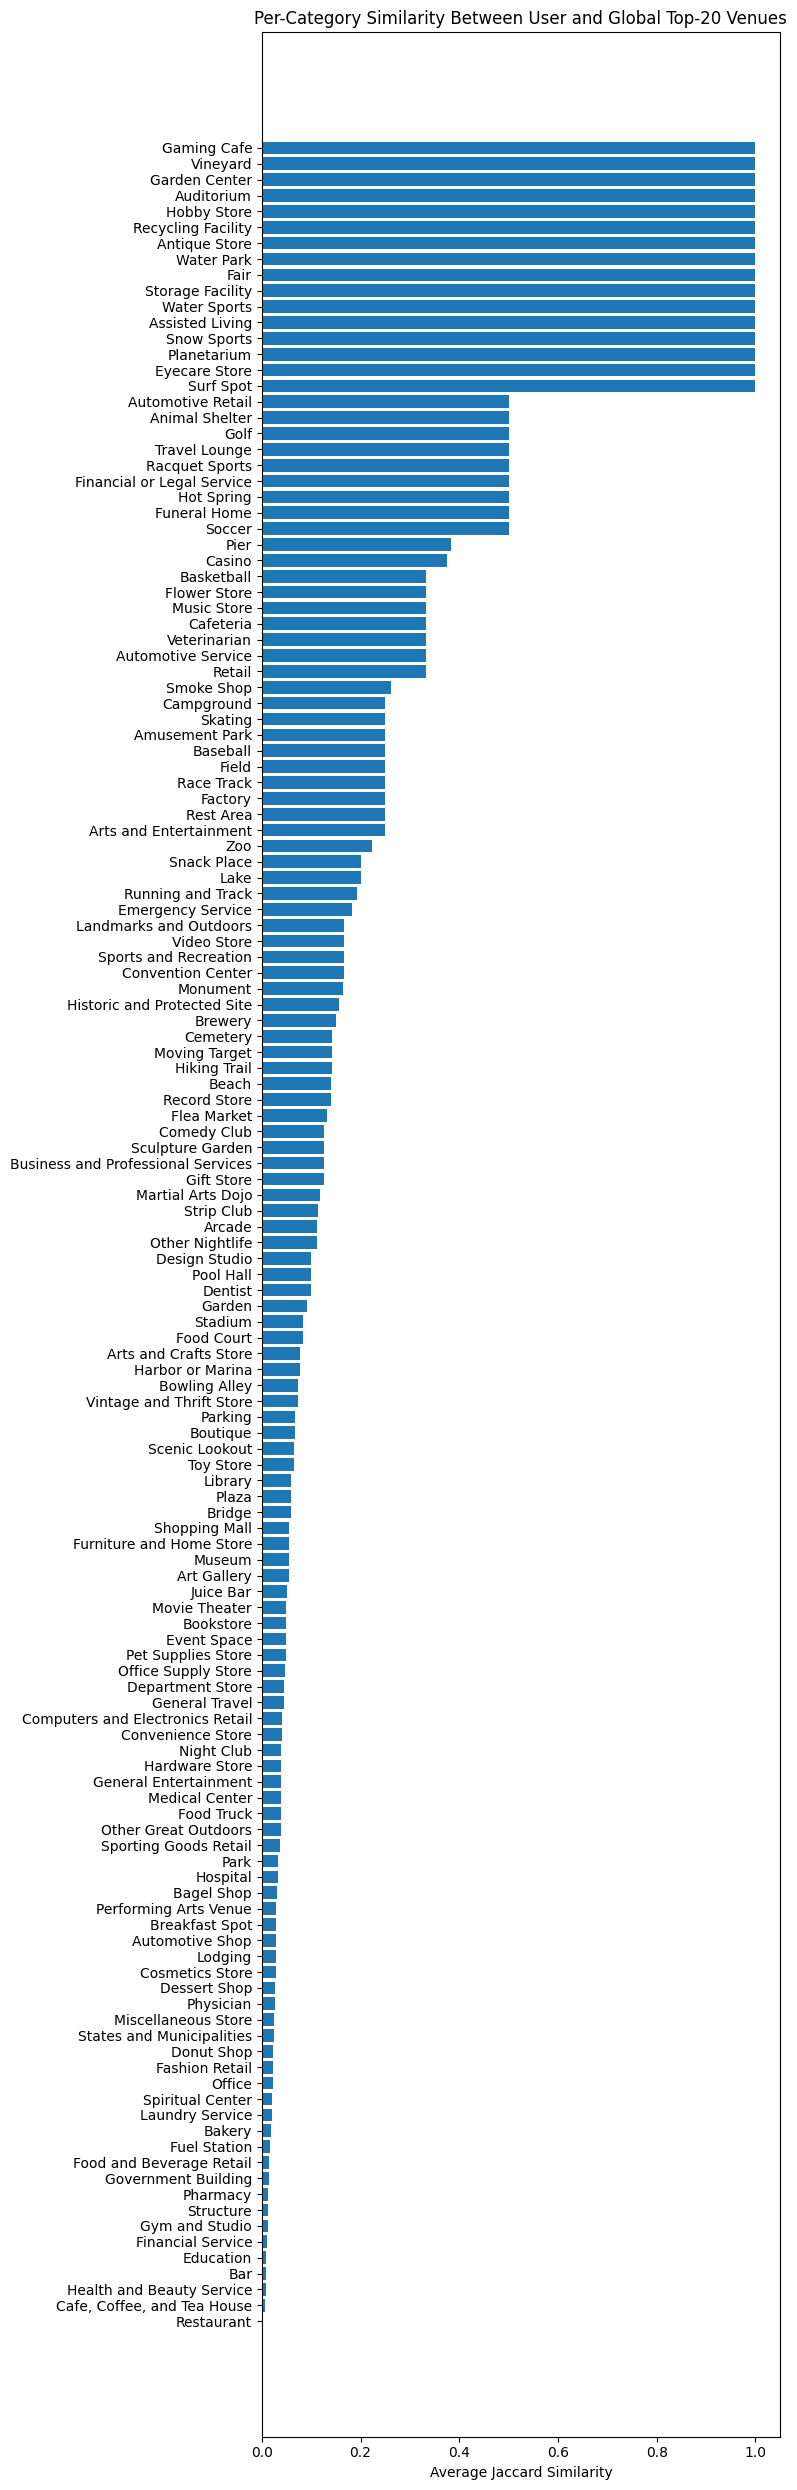

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming category_avg_sim is already defined
# category_avg_sim = {'Coffee Shop': 0.65, 'Art Gallery': 0.12, ...}

# Convert to DataFrame and sort
df_similarity = pd.DataFrame.from_dict(category_avg_sim, orient='index', columns=['Avg_Jaccard_Similarity'])
df_similarity = df_similarity.sort_values(by='Avg_Jaccard_Similarity', ascending=True)  # low to high for horizontal bars

# Plot horizontal bar chart
plt.figure(figsize=(8, 25))
plt.barh(df_similarity.index, df_similarity['Avg_Jaccard_Similarity'])
plt.xlabel('Average Jaccard Similarity')
plt.title(f'Per-Category Similarity Between User and Global Top-{z} Venues')
plt.tight_layout()
plt.show()
